In [1]:
import ants
import numpy as np

# Loading the sample data from ANTs

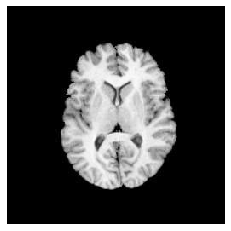

In [2]:
reference_image = ants.image_read(ants.get_ants_data('r27'))
ants.plot(reference_image)

# Showing the ANTsImage object.
The sample image is a 256x256 image. It is a grayscale image and hence has 1 component.

In [3]:
reference_image


ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256)
	 Spacing    : (1.0, 1.0)
	 Origin     : (0.0, 0.0)
	 Direction  : [1. 0. 0. 1.]

# Getting a cropped image from the original image
The size of the cropped image is defined by patch_size. If patch_size is P, then the cropped image is of size PxP.

In [4]:
def get_patch(reference_image, x1, y1, patch_size):
    #x = reference_image.shape[0]//2
    #y = reference_image.shape[1]//2
    #k = patch_size
    patch = ants.crop_indices(reference_image,(x1,y1), (x1+patch_size,y1+patch_size))
    return patch

# ANTs Registration

In [5]:
def register_image(fixed, moving):
    reg = ants.registration(fixed, moving, type_of_transform="SyNRA", verbose=True) # SyNRA
    return reg

# Measuring the global warping
Calculating the sum of absolute value of each pixel in the log jacobian determinant image of the moving image after registration.

In [6]:
def calculate_global_warping(fixed, transform_file):
    jac = ants.create_jacobian_determinant_image(fixed,transform_file,1,0)
    return np.sum(np.abs(jac.numpy()))

# Calculating Metrics

In [7]:
from skimage.metrics import structural_similarity as s_sim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import hausdorff_distance as h_dis
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse

def calculate_metrics(fixed, moving):
    fi = fixed.clone('float').numpy()
    mi = moving.clone('float').numpy()
    ssim = s_sim(fi, mi)
    mutualinfo = ants.image_mutual_information(fixed, moving)
    psnrval = psnr(fi,mi, data_range=255.0)
    hdis = h_dis(fi, mi)
    mseval = mse(fi, mi)
    nrmseval = nrmse(fi, mi)
    return ssim, mutualinfo, psnrval, hdis, mseval, nrmseval
    

# Sliding Registration
Sliding the cropped image through a smaller region in the original image and registering at every position of (x,y).

In this case, our cropped image (tissue block) is taken from the position (103, 103) in the image. We slide this cropped image from (95,95) to (105,105) and register at every position of (x,y). We calculate the global warping for each registration. Theoretically, after the sliding registration is complete, our best match should be at position (103,103).

In [8]:
def sliding_registration(reference_image, moving_image, patch_size):
    image_dims = [reference_image.shape[0], reference_image.shape[1]]
    jac_all = []
    reg_dict = {}
    #patch_size = 8
    num = 1
    for i in range(95,105): # image_dims[0]-patch_size
        for j in range(95,105): # image_dims[1]-patch_size
            print("Registration Number:" + str(num))
            num += 1
            fixed = get_patch(reference_image, i, j, patch_size)
            #moving = get_patch(reference_image, i, j, patch_size)
            reg = register_image(fixed, moving_image)
            #print(reg)
            if len(reg['fwdtransforms']) != 0:
                print("NON-ZERO TRANSFORM")
                jac = calculate_global_warping(fixed, reg['fwdtransforms'][0])
                
                ssim1, mutualinfo1, psnrval1, hdis1, mseval1, nrmseval1 = calculate_metrics(fixed, fixed)
                ssim2, mutualinfo2, psnrval2, hdis2, mseval2, nrmseval2 = calculate_metrics(fixed, moving_image)
                ssim3, mutualinfo3, psnrval3, hdis3, mseval3, nrmseval3 = calculate_metrics(moving_image, reg['warpedmovout'])
                ssim4, mutualinfo4, psnrval4, hdis4, mseval4, nrmseval4 = calculate_metrics(fixed, reg['warpedmovout'])
                
                metrics = {'jac': jac, 
                        'pos': (i,j), 
                        'ssim': (ssim1, ssim2, ssim3, ssim4), 
                        'mi': (mutualinfo1,mutualinfo2, mutualinfo3, mutualinfo4),
                        'psnr': (psnrval1, psnrval2, psnrval3, psnrval4), 
                        'hdis': (hdis1, hdis2, hdis3, hdis4), 
                        'mse': (mseval1, mseval2, mseval3, mseval4),
                        'nrmse': (nrmseval1, nrmseval2, nrmseval3, nrmseval4)}
                
                jac_all.append(metrics)
                reg_dict[(i,j)] = (reg,fixed)
            else:
                print("ZERO TRANSFORM")
    return jac_all, reg_dict

# Taking a central cropped image and running the sliding registration
We take a cropped image of size 50x50 from the center of the original image. The (x,y) coordinate of the origin of cropped image is (103,103). 

In [9]:
# Get central patch (tissue block)
patch_size = 50
x1_ref = (reference_image.shape[0]//2) - (patch_size//2)
y1_ref = (reference_image.shape[1]//2) - (patch_size//2)
moving_image = get_patch(reference_image, x1_ref, y1_ref, patch_size)
#ants.plot(moving_image)
print(f"Position of cropped image(tissue block): ({x1_ref}, {y1_ref})")


Position of cropped image(tissue block): (103, 103)


In [10]:
metrics, reg_dict = sliding_registration(reference_image,moving_image, patch_size)

Registration Number:1
NON-ZERO TRANSFORM
Registration Number:2


/Users/narender/opt/anaconda3/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning:

divide by zero encountered in double_scalars



NON-ZERO TRANSFORM
Registration Number:3
NON-ZERO TRANSFORM
Registration Number:4
NON-ZERO TRANSFORM
Registration Number:5
NON-ZERO TRANSFORM
Registration Number:6
NON-ZERO TRANSFORM
Registration Number:7
NON-ZERO TRANSFORM
Registration Number:8
NON-ZERO TRANSFORM
Registration Number:9
NON-ZERO TRANSFORM
Registration Number:10
NON-ZERO TRANSFORM
Registration Number:11
NON-ZERO TRANSFORM
Registration Number:12
NON-ZERO TRANSFORM
Registration Number:13
NON-ZERO TRANSFORM
Registration Number:14
NON-ZERO TRANSFORM
Registration Number:15
NON-ZERO TRANSFORM
Registration Number:16
NON-ZERO TRANSFORM
Registration Number:17
NON-ZERO TRANSFORM
Registration Number:18
NON-ZERO TRANSFORM
Registration Number:19
NON-ZERO TRANSFORM
Registration Number:20
NON-ZERO TRANSFORM
Registration Number:21
NON-ZERO TRANSFORM
Registration Number:22
NON-ZERO TRANSFORM
Registration Number:23
NON-ZERO TRANSFORM
Registration Number:24
NON-ZERO TRANSFORM
Registration Number:25
NON-ZERO TRANSFORM
Registration Number:26

# Total number of registrations done during sliding registration
We do a total of 100 registrations

In [11]:
print(len(metrics))

100


# Get the best Match position
We get the best match's position. The best match should have the lowest value of the global warping. In our case, it should be at position (103,103) since that is the position from where the original cropped image was taken.

The first value in the given output list of all glaobal warping values will the best match. Each metric shows a list of 4 values because we calculate the metric for 4 cases (fixed-fixed, fixed-moving, moving-warped, fixed-warped). The fixed-fixed (calculating the metric for fixed image with the same fixed image) case and the moving-moving case show what the value would be for each metric in case of a perfect match. We are mainly interested in the 4th case (fixed-warped) as this gives the metric between the fixed image (reference block) and the moving image (tissue block) after the registration/warping

In [12]:
#jac_all.sort(key=lambda x:x[0])
metrics_sorted = sorted(metrics, key=lambda x: x['ssim'][3], reverse=True)
metrics_sorted

[{'jac': 45.780563,
  'pos': (103, 103),
  'ssim': (1.0, 1.0, 0.9976234578633073, 0.9976234578633073),
  'mi': (-1.6885265641870515,
   -1.6885265641870515,
   -1.6289795811052323,
   -1.6289795811052323),
  'psnr': (inf, inf, 40.94886059793097, 40.94886059793097),
  'hdis': (0.0, 0.0, 1.0, 1.0),
  'mse': (0.0, 0.0, 5.226299586056452, 5.226299586056452),
  'nrmse': (0.0, 0.0, 0.012656817658184836, 0.012656817658184836)},
 {'jac': 54.077133,
  'pos': (103, 104),
  'ssim': (1.0, 0.8333658999142736, 0.8301254200475112, 0.98107779797984),
  'mi': (-1.690907016966741,
   -1.6841997173187362,
   -1.5899241993855966,
   -1.5576068065742634),
  'psnr': (inf, 25.06247181122894, 18.651675776076452, 19.67407025236664),
  'hdis': (0.0, 1.0, 1.0, 1.0),
  'mse': (0.0, 202.6904, 886.9778677386727, 700.927881409532),
  'nrmse': (0.0,
   0.07872204062000729,
   0.16488599317544975,
   0.14639168890532564)},
 {'jac': 50.774178,
  'pos': (103, 102),
  'ssim': (1.0, 0.836318957314534, 0.8318781117623644, 

In [13]:
# USE ONLY IF USING NON-LOG JACOBIAN DETERMINANT IMAGE FOR MEASURING GLOBAL WARPING.

#jac_all_c = []
#for i,j,k in jac_all:
#    val = (abs(i-(i - patch_size**2)), j, k) 
#    jac_all_c.append(val)

In [14]:
#jac_all_c.sort(key=lambda x:x[0])
#jac_all_c

In [15]:
len(reg_dict)

100

# Details of registered image and corresponding fixed image
Change the value of (x1_ref, y1_ref) to get details of registered image and fixed image at that index/position.

In [16]:
ref_match = reg_dict[(x1_ref,y1_ref)]
ref_match

({'warpedmovout': ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (50, 50)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (103.0, 103.0)
  	 Direction  : [1. 0. 0. 1.],
  'warpedfixout': ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (50, 50)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (103.0, 103.0)
  	 Direction  : [1. 0. 0. 1.],
  'fwdtransforms': ['/var/folders/1g/0yylg_z95lx5zcn3dpkgb9tr0000gn/T/tmp6mw59dkl1Warp.nii.gz',
   '/var/folders/1g/0yylg_z95lx5zcn3dpkgb9tr0000gn/T/tmp6mw59dkl0GenericAffine.mat'],
  'invtransforms': ['/var/folders/1g/0yylg_z95lx5zcn3dpkgb9tr0000gn/T/tmp6mw59dkl0GenericAffine.mat',
   '/var/folders/1g/0yylg_z95lx5zcn3dpkgb9tr0000gn/T/tmp6mw59dkl1InverseWarp.nii.gz']},
 ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (50, 50)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (103.0, 103.0)
 	 Direction  : [1. 0. 0. 1.])

# Some Helpful visualizations
1. Moving image after registration
2. Moving image before registration
3. Fixed image at that position

In this case, all three look the same because we are visualizing the cropped image and the best match registration.

In [17]:
ref_fixed = ref_match[1]
ref_reg = ref_match[0]

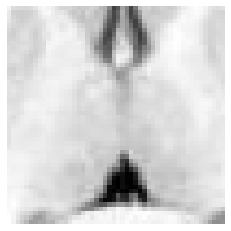

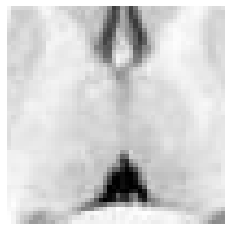

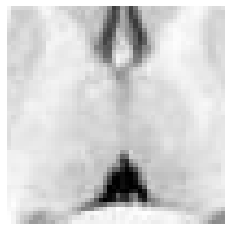

In [18]:
ants.plot(ref_reg['warpedmovout'])
ants.plot(moving_image)
ants.plot(ref_fixed)

Visualizing:
1. Warped image overlayed on moving image
2. Moving image overlayed on Fixed image
3. Warped image overlayed on Fixed image

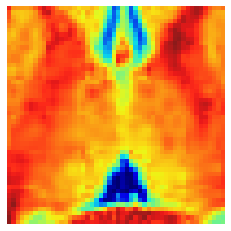

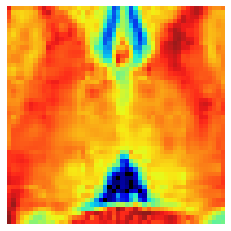

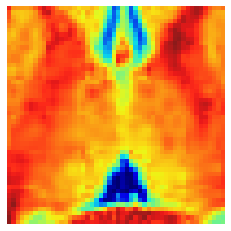

In [19]:
ants.plot(moving_image, ref_reg['warpedmovout'])
ants.plot(ref_fixed, moving_image)
ants.plot(ref_fixed, ref_reg['warpedmovout'])

Visualizing the grid deformation/warping of moving image after it is registered to the fixed image.

In this case, there is no warping because we are visualizing the best match.

In [20]:
mywarpedgrid = ants.create_warped_grid( moving_image, grid_directions=(True,True),
                        transform=ref_reg['fwdtransforms'], fixed_reference_image=ref_fixed )

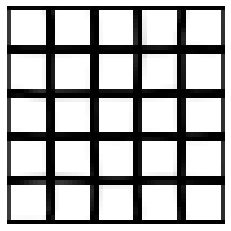

In [21]:
ants.plot(mywarpedgrid)

Visualizing the Log Jacobian Determinant(LJD) Image and looking at the value of the Log Jacobian Determinant for each pixel.

If LJD = 0 -> No change

If LJD = -ve -> Contraction

If LJD = +ve -> Expansion

In [22]:
jac_viz = ants.create_jacobian_determinant_image(ref_fixed,ref_reg['fwdtransforms'][0],1,0)

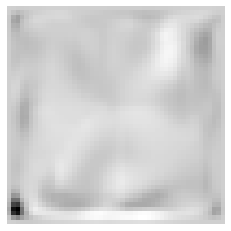

In [23]:
ants.plot(jac_viz)

In [24]:
jac_viz[:][:]

array([[ 0.0000000e+00, -3.4687142e-03, -1.0466211e-02, ...,
        -4.7631256e-02, -1.5744537e-02,  0.0000000e+00],
       [-1.5252868e-03, -1.9996723e-02, -4.9102563e-02, ...,
        -2.0059979e-01, -7.2252981e-02, -2.2576267e-03],
       [-4.5852247e-03, -3.2421347e-02, -6.2952653e-02, ...,
        -2.3106059e-01, -9.4695747e-02, -6.7995465e-03],
       ...,
       [ 1.8421237e-03, -2.0835037e-06, -1.6767735e-02, ...,
        -5.9888199e-02, -2.6765833e-02, -2.4484000e-03],
       [ 6.1715388e-04, -4.2514359e-03, -1.8776430e-02, ...,
        -5.1651809e-02, -1.9434730e-02, -8.1433821e-04],
       [ 0.0000000e+00, -1.7417325e-03, -5.2393572e-03, ...,
        -1.2192174e-02, -4.0538269e-03,  0.0000000e+00]], dtype=float32)